<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/master/notebooks/named-entity-recognition-conll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition

This notebook contains code to successfully perform named entity recognition on
text from the CONLL 2003 dataset.

### Import Dependencies and Download Dataset

In [106]:
import os

import tensorflow as tf

import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns

In [1]:
!wget -q https://data.deepai.org/conll2003.zip
!unzip -q conll2003.zip -d conll
!rm conll2003.zip

### Dataset Processing

First, we split process the train, valid, and test .txt files to be separated by
sentences with their corresponding entity classifications.


In [7]:
def split_text_label(filename):
    f = open(filename)

    split_labeled_text = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == '\n':
            if len(sentence) > 0:
                split_labeled_text.append(sentence)
                sentence = []
            continue
        
        splits = line.split(' ')
        sentence.append([splits[0], splits[-1].rstrip("\n")])
    
    if len(sentence) > 0:
        split_labeled_text.append(sentence)
        sentence = []
    
    return split_labeled_text

In [9]:
split_train = split_text_label('conll/train.txt')
split_val = split_text_label('conll/valid.txt')
split_test = split_text_label('conll/test.txt')

Next, we determine what words are needed in our word mapping. We also create
a list of the labeled entities.

In [12]:
word_set = set()
label_set = set()

for data in [split_train, split_val, split_test]:
    for sentence in data:
        for word, label in sentence:
            word_set.add(word.lower())
            label_set.add(label)

Create the mappings for words and labels.

In [163]:
# Sort the set to ensure '0' is assigned to O
sorted_labels = sorted(list(label_set), key=len)

# Create mapping for labels
label_to_idx = {}
for index, label in enumerate(sorted_labels):
    label_to_idx[label] = index

idx_to_label = {value: key for key, value in label_to_idx.items()}

# Create mapping for words
word_to_idx = {}
PADDING_TOKEN = 'PADDING_TOKEN'
UNKNOWN_TOKEN = 'UNKNOWN_TOKEN'

word_to_idx[PADDING_TOKEN] = len(word_to_idx)
word_to_idx[UNKNOWN_TOKEN] = len(word_to_idx)

for word in word_set:
    word_to_idx[word] = len(word_to_idx)

idx_to_word = {value: key for key, value in word_to_idx.items()}

Convert the string data to its integer representation.

In [16]:
def perform_mapping(data, word_to_idx, label_to_idx):
    sentences = []
    labels = []
    for sentence in data:
        word_indices = []
        label_indices = []

        for word, label in sentence:
            lower_word = word.lower()
            if lower_word in word_to_idx:
                word_idx = word_to_idx[lower_word]
            else:
                word_idx = word_to_idx[UNKNOWN_TOKEN]
            
            word_indices.append(word_idx)
            label_indices.append(label_to_idx[label])
        
        sentences.append(word_indices)
        labels.append(label_indices)
    
    return sentences, labels

In [17]:
train_sentences, train_labels = perform_mapping(split_train, word_to_idx, label_to_idx)
val_sentences, val_labels = perform_mapping(split_val, word_to_idx, label_to_idx)
test_sentences, test_labels = perform_mapping(split_test, word_to_idx, label_to_idx)

Add padding to the sequences to make it easier to send through our deep
learning model.

In [20]:
def pad_sentences(sentences, labels, max_len, padding='post'):
    padded_sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences, max_len, padding=padding)
    padded_labels = tf.keras.preprocessing.sequence.pad_sequences(labels, max_len, padding=padding)
    
    return padded_sentences, padded_labels

In [73]:
MAX_SEQ_LEN = 128

train_features, train_labels = pad_sentences(train_sentences, train_labels, MAX_SEQ_LEN)
val_features, val_labels = pad_sentences(val_sentences, val_labels, MAX_SEQ_LEN)
test_features, test_labels = pad_sentences(test_sentences, test_labels, MAX_SEQ_LEN)

### Model Creation

We now create our simple Named-Entity-Recognition Model.

In [175]:
class NERModel(tf.keras.Model):
    def __init__(self, input_dim, num_labels, max_seq_len):
        super(NERModel, self).__init__()

        embed_output_dim = 128

        self.embedding = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=embed_output_dim, input_length=max_seq_len, mask_zero=True)
        self.conv1 = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu')
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))
        self.dense = tf.keras.layers.Dense(num_labels)

    def call(self, x, **kwargs):
        x = self.embedding(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.lstm(x)
        x = self.dense(x)
        x = tf.nn.softmax(x)

        return x

### Metrics

Using sklearn, we can create a few metrics to help us evaluate the model.

Wrapping the sklearn functions allows us to get metric scores by sending
y_true and y_pred as batches and also allows us to specify the average
setting to *macro*.

In [48]:
def precision_score(y_true, y_pred):
    rank = len(y_true.shape)
    assert rank == 1 or rank == 2
    if len(y_true.shape) == 2:
        precision = []
        for y_true_single, y_pred_single in zip(y_true, y_pred):
            precision.append(metrics.precision_score(y_true_single, y_pred_single, average='macro'))
        return tf.math.reduce_mean(precision)
    else:
        return metrics.precision_score(y_true, y_pred, average='macro')

def recall_score(y_true, y_pred):
    rank = len(y_true.shape)
    assert rank == 1 or rank == 2
    if len(y_true.shape) == 2:
        recall = []
        for y_true_single, y_pred_single in zip(y_true, y_pred):
            recall.append(metrics.recall_score(y_true_single, y_pred_single, average='macro'))
        return tf.math.reduce_mean(recall)
    else:
        return metrics.recall_score(y_true, y_pred, average='macro')

def f1_score(y_true, y_pred):
    rank = len(y_true.shape)
    assert rank == 1 or rank == 2
    if len(y_true.shape) == 2:
        f1 = []
        for y_true_single, y_pred_single in zip(y_true, y_pred):
            f1.append(metrics.f1_score(y_true_single, y_pred_single, average='macro'))
        return tf.math.reduce_mean(f1)
    else:
        return metrics.f1_score(y_true, y_pred, average='macro')

### Training

Create our model training object.

In [179]:
class Train():
    def __init__(self, train_features, train_labels, val_features, val_labels, num_words, num_labels, max_seq_len, model=None):
        self.epochs = 3
        self.batch_size = 32
        self.embedding_dim = 128

        self.model = NERModel(input_dim=num_words, num_labels=num_labels, max_seq_len=max_seq_len) if model is None else model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

        self.train_size = train_features.shape[0]
        self.train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))\
                                            .shuffle(train_features.shape[0], reshuffle_each_iteration=True)\
                                            .batch(self.batch_size, drop_remainder=True)

        self.val_size = val_features.shape[0]
        self.val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels))\
                                          .batch(self.batch_size, drop_remainder=True)

        # Metrics
        self.train_loss = tf.keras.metrics.Mean('train_loss')
        self.train_precision = tf.keras.metrics.Mean('train_precision')
        self.train_recall = tf.keras.metrics.Mean('train_recall')
        self.train_f1 = tf.keras.metrics.Mean('train_f1')

        self.val_loss = tf.keras.metrics.Mean('val_loss')
        self.val_precision = tf.keras.metrics.Mean('val_precision')
        self.val_recall = tf.keras.metrics.Mean('val_recall')
        self.val_f1 = tf.keras.metrics.Mean('val_f1')
    
    @tf.function
    def train_step(self, words, labels):
        with tf.GradientTape() as tape:
            output = self.model(words, training=True)
            loss = self.loss_fn(labels, output)
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(list(zip(gradients, self.model.trainable_variables)))

        predictions = tf.argmax(output, 2)
        self.train_loss(loss)
        self.train_precision(tf.py_function(precision_score, [labels, predictions], Tout=[tf.float64]))
        self.train_recall(tf.py_function(recall_score, [labels, predictions], Tout=[tf.float64]))
        self.train_f1(tf.py_function(f1_score, [labels, predictions], Tout=[tf.float64]))
    
    @tf.function
    def val_step(self, words, labels):
        output = self.model(words, training=False)
        loss = self.loss_fn(labels, output)

        predictions = tf.argmax(output, 2)
        self.val_loss(loss)
        self.val_precision(tf.py_function(precision_score, [labels, predictions], Tout=[tf.float64]))
        self.val_recall(tf.py_function(recall_score, [labels, predictions], Tout=[tf.float64]))
        self.val_f1(tf.py_function(f1_score, [labels, predictions], Tout=[tf.float64]))
    
    def __call__(self):
        for epoch in range(self.epochs):
            self.train_loss.reset_states()
            self.train_precision.reset_states()
            self.train_recall.reset_states()
            self.train_f1.reset_states()

            self.val_loss.reset_states()
            self.val_precision.reset_states()
            self.val_recall.reset_states()
            self.val_f1.reset_states()

            # Training Loop
            train_loop = tqdm(total=self.train_size//self.batch_size, position=0, leave=True)
            for words, labels in self.train_dataset:
                self.train_step(words, labels)
                train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
                    epoch, self.train_loss.result(), self.train_precision.result(), self.train_recall.result(), self.train_f1.result()
                ))
                train_loop.update(1)
            train_loop.close()

            # Validation Loop
            val_loop = tqdm(total=self.val_size//self.batch_size, position=0, leave=True)
            for words, labels in self.val_dataset:
                self.val_step(words, labels)
                val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
                    epoch, self.val_loss.result(), self.val_precision.result(), self.val_recall.result(), self.val_f1.result()
                ))
                val_loop.update(1)
            val_loop.close()

Train the model. The created model will be an attribute of the train object
and will be used later on during evaluation.

In [180]:
EMBEDDING_DIM = 128
num_words = len(word_to_idx)
num_labels = len(label_to_idx)

train = Train(train_features, train_labels, val_features, val_labels, num_words, num_labels, MAX_SEQ_LEN)
train()

  0%|          | 0/438 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Train - Epoch: 0, Loss: 0.0745, Precision: 0.6031, Recall: 0.6022, F1: 0.5998: 100%|██████████| 438/438 [03:15<00:00,  2.24it/s]
Val   - Epoch: 0, Loss: 0.0319, Precision: 0.7315, Recall: 0.7233, F1: 0.7228: 100%|██████████| 101/101 [00:19<00:00,  5.24it/s]
Train - Epoch: 1, Loss: 0.0142, Precision: 0.8791, Recall: 0.8743, F1: 0.8737: 100%|██████████| 438/438 [03:14<00:0

### Evaluate

Evaluate the performance of our model on the test set.

In [183]:
@tf.function
def test_step(model, words):
    output = model(words, training=False)
    return tf.argmax(output, 2)

def evaluate(model, test_features, test_labels, idx_to_label, idx_to_word, example_words=100):
    batch_size = 32
    test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(batch_size)

    x_true = []
    y_true = []
    y_pred = []
    test_loop = tqdm(total=int(np.ceil(test_features.shape[0] / batch_size)), position=0, leave=True)
    for words, labels in test_dataset:
        predictions = test_step(model, words)
        test_loop.update(1)

        x_true.extend(tf.keras.backend.flatten(words).numpy().tolist())
        y_true.extend(tf.keras.backend.flatten(labels).numpy().tolist())
        y_pred.extend(tf.keras.backend.flatten(predictions).numpy().tolist())

    test_loop.close()
    
    x_true = [idx_to_word[word_idx] for word_idx in x_true]
    y_true = [idx_to_label[label_idx] for label_idx in y_true]
    y_pred = [idx_to_label[label_idx] for label_idx in y_pred]

    print('Classification Report:')
    print(metrics.classification_report(y_true, y_pred, digits=4))

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

    entity_labels = list(idx_to_label.values())[::-1]
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=entity_labels, yticklabels=entity_labels)

    plt.title('Confusion Matrix', fontdict={'fontsize': 20})
    plt.xlabel('Predicted', fontdict={'fontsize':15})
    plt.ylabel('Actual', fontdict={'fontsize':15})
    plt.pause(.01)

    print('Examples:')
    count = 0
    for word, predicted, actual in zip(x_true, y_pred, y_true):
        if word != PADDING_TOKEN:
            print(word, '-', predicted, '-', actual)
            count += 1
            if count == example_words:
                break

100%|██████████| 108/108 [00:10<00:00, 10.71it/s]


Classification Report:
              precision    recall  f1-score   support

       B-LOC     0.8308    0.8357    0.8332      1668
      B-MISC     0.7307    0.7265    0.7286       702
       B-ORG     0.6299    0.6671    0.6480      1661
       B-PER     0.9364    0.6283    0.7520      1617
       I-LOC     0.6012    0.7626    0.6724       257
      I-MISC     0.4533    0.6065    0.5188       216
       I-ORG     0.4530    0.6527    0.5348       835
       I-PER     0.9514    0.6946    0.8030      1156
           O     0.9972    0.9978    0.9975    433872

    accuracy                         0.9924    441984
   macro avg     0.7315    0.7302    0.7209    441984
weighted avg     0.9929    0.9924    0.9924    441984



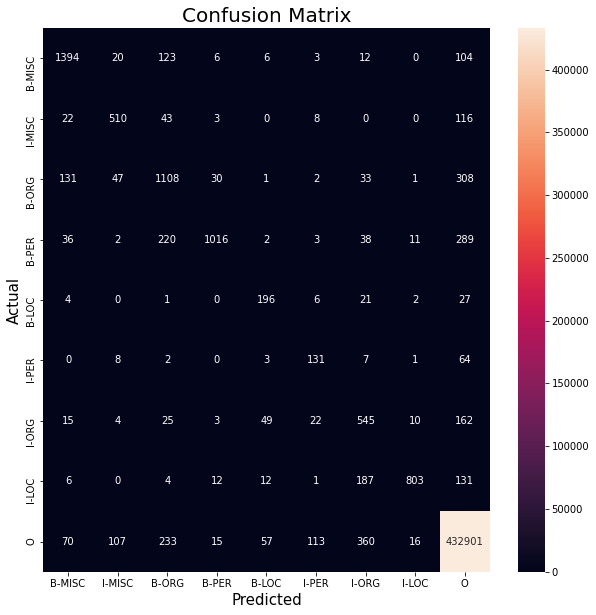

Examples:
soccer - O - O
- - O - O
japan - B-LOC - B-LOC
get - O - O
lucky - O - O
win - O - O
, - O - O
china - B-LOC - B-PER
in - O - O
surprise - O - O
defeat - O - O
. - O - O
nadim - B-ORG - B-PER
ladki - O - I-PER
al-ain - B-ORG - B-LOC
, - O - O
united - B-LOC - B-LOC
arab - I-LOC - I-LOC
emirates - I-LOC - I-LOC
1996-12-06 - O - O
japan - B-LOC - B-LOC
began - O - O
the - O - O
defence - O - O
of - O - O
their - O - O
asian - B-MISC - B-MISC
cup - I-MISC - I-MISC
title - O - O
with - O - O
a - O - O
lucky - O - O
2-1 - O - O
win - O - O
against - O - O
syria - B-LOC - B-LOC
in - O - O
a - O - O
group - O - O
c - O - O
championship - O - O
match - O - O
on - O - O
friday - O - O
. - O - O
but - O - O
china - B-LOC - B-LOC
saw - O - O
their - O - O
luck - O - O
desert - O - O
them - O - O
in - O - O
the - O - O
second - O - O
match - O - O
of - O - O
the - O - O
group - O - O
, - O - O
crashing - O - O
to - O - O
a - O - O
surprise - O - O
2-0 - O - O
defeat - O - O
to - O - O
ne

In [184]:
evaluate(train.model, test_features, test_labels, idx_to_label, idx_to_word)